In [ ]:
import os
import shutil
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from IPython.display import display, Image

In [ ]:
# 1. Paths and directory setup
# -----------------------------
BASE = '/content'
# Original uploaded folders (as the user said they will be uploaded directly under /content)
orig_undamaged_train = os.path.join(BASE, 'Undamaged Plates Train')
orig_damaged_train = os.path.join(BASE, 'Damaged Plates Train')
orig_undamaged_test = os.path.join(BASE, 'Undamaged Plates Test')
orig_damaged_test = os.path.join(BASE, 'Damaged Plates Test')


# Working structure for Keras ImageDataGenerator
DATA_DIR = os.path.join(BASE, 'plate_data')
train_dir = os.path.join(DATA_DIR, 'train')
test_dir = os.path.join(DATA_DIR, 'test')


# helper to create directories and copy files
def prepare_dir(src, dst):
    os.makedirs(dst, exist_ok=True)
    if os.path.isdir(src):
        files = glob.glob(os.path.join(src, '*'))
        for f in files:
            if os.path.isfile(f):
                shutil.copy(f, dst)
    else:
        print(f"Warning: source folder not found: {src}")


# create class subfolders: 'undamaged' and 'damaged'
prepare_dir(orig_undamaged_train, os.path.join(train_dir, 'undamaged'))
prepare_dir(orig_damaged_train, os.path.join(train_dir, 'damaged'))
prepare_dir(orig_undamaged_test, os.path.join(test_dir, 'undamaged'))
prepare_dir(orig_damaged_test, os.path.join(test_dir, 'damaged'))


print('Train folder counts:')
print('undamaged:', len(os.listdir(os.path.join(train_dir, 'undamaged'))))
print('damaged:', len(os.listdir(os.path.join(train_dir, 'damaged'))))
print('Test folder counts:')
print('undamaged:', len(os.listdir(os.path.join(test_dir, 'undamaged'))))
print('damaged:', len(os.listdir(os.path.join(test_dir, 'damaged'))))

Train folder counts:
undamaged: 17
damaged: 210
Test folder counts:
undamaged: 3
damaged: 10


In [ ]:
# 2. Image data pipeline
# -----------------------------
IMG_SIZE = (224, 224)
BATCH = 16


train_datagen = ImageDataGenerator(rescale=1./255,
rotation_range=15,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.05,
zoom_range=0.1,
horizontal_flip=True,
validation_split=0.15)


train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=IMG_SIZE,
batch_size=BATCH,
class_mode='binary',
subset='training')


val_generator = train_datagen.flow_from_directory(
train_dir,
target_size=IMG_SIZE,
batch_size=BATCH,
class_mode='binary',
subset='validation')


# test generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=IMG_SIZE,
batch_size=1,
class_mode='binary',
shuffle=False)

Found 194 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


In [ ]:
# 3. Build a simple CNN
# -----------------------------
def build_cnn(input_shape=(*IMG_SIZE, 3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


cnn_model = build_cnn()
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4. Train CNN
# -----------------------------
EPOCHS = 12
history = cnn_model.fit(
train_generator,
validation_data=val_generator,
epochs=EPOCHS
)


# save the cnn model
cnn_model.save('/content/plate_cnn_model.h5')
print('Saved CNN model to /content/plate_cnn_model.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7646 - loss: 0.7626 - val_accuracy: 0.9394 - val_loss: 0.1403
Epoch 2/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9344 - loss: 0.2225 - val_accuracy: 0.9394 - val_loss: 0.1340
Epoch 3/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9412 - loss: 0.2248 - val_accuracy: 0.9394 - val_loss: 0.2901
Epoch 4/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9273 - loss: 0.2682 - val_accuracy: 0.9394 - val_loss: 0.1047
Epoch 5/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9030 - loss: 0.2076 - val_accuracy: 0.9394 - val_loss: 0.0781
Epoch 6/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9360 - loss: 0.1491 - val_accuracy: 0.9394 - val_loss: 0.0747
Epoch 7/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9333 - loss: 0.1637 - val_accuracy: 1.0000 - val_loss: 0.0871
Epoch 8/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9598 - loss: 0.1235 - val_accuracy: 0.9394 - val_loss:

Saved CNN model to /content/plate_cnn_model.h5


In [ ]:
# 5. NLP model (sentiment) -- simple LSTM on labelled csvs

# Load data from the CSV files
pos_file = '/content/positive_plate_reviews.csv'
neg_file = '/content/negative_plate_reviews.csv'

# Check for alternative filenames
if not os.path.exists(pos_file) or os.stat(pos_file).st_size == 0:
    pos_file = '/content/positive_plate_reviews (1).csv'
if not os.path.exists(neg_file) or os.stat(neg_file).st_size == 0:
    neg_file = '/content/negative_plate_reviews (1).csv'


try:
    pos_df = pd.read_csv(pos_file)
    neg_df = pd.read_csv(neg_file)
    pos = list(zip(pos_df['review_text'].tolist(), [1] * len(pos_df)))
    neg = list(zip(neg_df['review_text'].tolist(), [0] * len(neg_df)))
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Make sure the two CSV files are uploaded to /content.")
    pos = []
    neg = []
except KeyError as e:
    print(f"Error loading data: {e}. Make sure the CSV files have a 'review_text' column.")
    pos = []
    neg = []
except pd.errors.EmptyDataError as e:
    print(f"Error loading data: {e}. Make sure the CSV files are not empty.")
    pos = []
    neg = []


all_reviews = pos + neg
if len(all_reviews) == 0:
    raise RuntimeError('No review data loaded. Make sure the two CSV files are uploaded and not empty, and have a "review_text" column.')


texts, labels = zip(*all_reviews)
texts = list(texts)
labels = np.array(labels)


# split for training
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(texts, labels, test_size=0.15, random_state=42, stratify=labels)


# Tokenize
MAX_WORDS = 10000
MAX_LEN = 120
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)


X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq = tokenizer.texts_to_sequences(X_val_text)


X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')


# simple LSTM model
nlp_model = models.Sequential([
layers.Input(shape=(MAX_LEN,)),
layers.Embedding(MAX_WORDS, 64),
layers.Bidirectional(layers.LSTM(64)),
layers.Dense(64, activation='relu'),
layers.Dropout(0.5),
layers.Dense(1, activation='sigmoid')
])
nlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nlp_model.summary()


nlp_history = nlp_model.fit(
X_train_pad, y_train_text,
validation_data=(X_val_pad, y_val_text),
epochs=10,
batch_size=32
)


nlp_model.save('/content/plate_nlp_model.h5')
print('Saved NLP model to /content/plate_nlp_model.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 714,369 (2.73 MB)

 Trainable params: 714,369 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.6328 - loss: 0.6825 - val_accuracy: 1.0000 - val_loss: 0.5758
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9448 - loss: 0.5018 - val_accuracy: 1.0000 - val_loss: 0.2723
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9480 - loss: 0.2469 - val_accuracy: 1.0000 - val_loss: 0.0821
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0629 - val_accuracy: 1.0000 - val_loss: 0.0097
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 5.7856e-04
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy

Saved NLP model to /content/plate_nlp_model.h5



--- Real-time demonstration ---
Displaying test image: /content/plate_data/test/damaged/p220.jpg


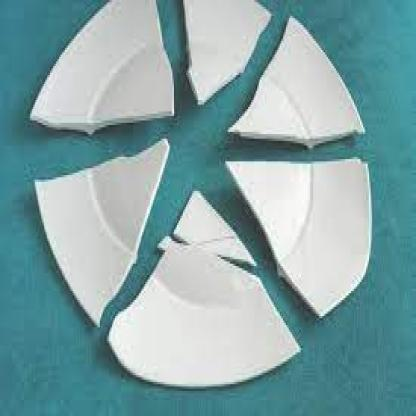

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Class mapping from generator: {'damaged': 0, 'undamaged': 1}
Image predicted as: damaged (prob=0.000)
This is a DAMAGED plate.
Image predicted as: damaged (prob=0.000)

Please type your comment about the displayed plate and press Enter:
good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Comment sentiment predicted: negative (prob=0.000)
Overall Negative Experience


In [ ]:
# 6. Real-time simulation in Colab: show an image, get a comment, evaluate
# -----------------------------
print('\n--- Real-time demonstration ---')
# We'll take a random image from the test set (user can modify to choose any image)
all_test_images = glob.glob(os.path.join(test_dir, '*', '*'))
if len(all_test_images) == 0:
    raise RuntimeError('No test images found. Check upload and folder names.')


sample_img_path = np.random.choice(all_test_images)
print('Displaying test image:', sample_img_path)
display(Image(filename=sample_img_path, width=400))


# Predict image class
from tensorflow.keras.preprocessing import image
img = image.load_img(sample_img_path, target_size=IMG_SIZE)
img_arr = image.img_to_array(img)/255.0
img_input = np.expand_dims(img_arr, axis=0)
img_pred_prob = cnn_model.predict(img_input)[0][0]
img_label = 0 if img_pred_prob < 0.5 else 1 # 0: undamaged, 1: damaged? -> we need to check class indices


# Note: ImageDataGenerator.flow_from_directory assigned classes alphabetically by folder name.
# Our folders were named 'undamaged' and 'damaged' -> alphabetically 'damaged' < 'undamaged'
# So class_indices mapping:
# e.g. {'damaged': 0, 'undamaged': 1}
# But we trained with those directories; let's retrieve mapping from train_generator
class_map = train_generator.class_indices
print('Class mapping from generator:', class_map)


# Interpret prediction according to mapping
# model outputs probability for class 'damaged' if generator maps damaged->1, else maps accordingly.
# Safer: get predicted class index with threshold 0.5
pred_index = int(img_pred_prob >= 0.5)
# find label name for that index
inv_map = {v:k for k,v in class_map.items()}
predicted_label_name = inv_map.get(pred_index, 'unknown')
print(f'Image predicted as: {predicted_label_name} (prob={img_pred_prob:.3f})')
# Added display line to indicate the predicted image type
print(f'This is a {predicted_label_name.upper()} plate.')


print(f'Image predicted as: {predicted_label_name} (prob={img_pred_prob:.3f})')

# Get user's comment (Colab input)
print('\nPlease type your comment about the displayed plate and press Enter:')
user_comment = input().strip()
if user_comment == '':
    user_comment = 'No comment provided.'


# Predict sentiment of comment
seq = tokenizer.texts_to_sequences([user_comment])
pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
sent_prob = nlp_model.predict(pad)[0][0]
sent_label = 'positive' if sent_prob>=0.5 else 'negative'
print(f'Comment sentiment predicted: {sent_label} (prob={sent_prob:.3f})')
if sent_label == 'positive' and predicted_label_name == 'damaged':
  print("Overall Negative Experience")
elif sent_label == 'negative' and predicted_label_name == 'damaged':
  print("Overall Negative Experience")
elif sent_label == 'positive' and predicted_label_name == 'damaged':
  print("Overall Negative Experience")
else:
  print("Overall Positive Experience")